In [2]:
import pandas as pd

from sklearn.linear_model import LinearRegression


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline


In [10]:
passengers = pd.read_csv('../00_data/flights_train.csv')


In [15]:

passengers['date']= pd.to_datetime(passengers['date'])
passengers['month']  = passengers.date.dt.month
passengers['step'] = range(len(passengers.index + 1))

passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        132 non-null    datetime64[ns]
 1   passengers  132 non-null    int64         
 2   month       132 non-null    int64         
 3   step        132 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 4.2 KB


In [16]:
passengers.head()

,date,passengers,month,step
0,1949-01-01,64,1,0
1,1949-02-01,75,2,1
2,1949-03-01,98,3,2
3,1949-04-01,93,4,3
4,1949-05-01,80,5,4


## Without AR-1

In [18]:
X = passengers[['month', 'step']]
y = passengers['passengers'].ravel()

print(X.shape, y.shape)

(132, 2) (132,)


In [119]:
trans = ColumnTransformer([
    ('pass', 'passthrough', ['step']),
    ('oh', OneHotEncoder(drop='first', sparse=True), ['month'])

],
    remainder = 'drop')

linreg = Pipeline([
    ('transform', trans),
    ('model', LinearRegression())
])

linreg.fit(X, y)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('pass', 'passthrough',
                                                  ['step']),
                                                 ('oh',
                                                  OneHotEncoder(drop='first'),
                                                  ['month'])])),
                ('model', LinearRegression())])

In [120]:
linreg.named_steps['transform'].get_feature_names_out()

array(['pass__step', 'oh__month_2', 'oh__month_3', 'oh__month_4',
       'oh__month_5', 'oh__month_6', 'oh__month_7', 'oh__month_8',
       'oh__month_9', 'oh__month_10', 'oh__month_11', 'oh__month_12'],
      dtype=object)

In [121]:
preds = linreg.predict(X)

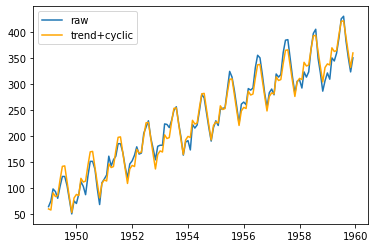

In [122]:
import matplotlib.pyplot as plt


plt.plot(passengers['date'], passengers['passengers'], label = 'raw')
plt.plot(passengers['date'], preds, color = 'orange', label = 'trend+cyclic')
# plt.plot(passengers['date'], preds, color = 'orange', label = 'cyclic')

plt.legend()

In [60]:
# extract remainder

passengers_ts = pd.DataFrame({
    'date' : passengers.date,
    'passengers' : passengers.passengers,
    'remainder': passengers.passengers - preds,
    'trend_seas' : preds,
    'step' : passengers.step
        })



In [106]:
linreg.named_steps['model'].coef_,linreg.named_steps['model'].coef_.shape, linreg.named_steps['model'].intercept_

(array([  2.32342172,  -4.41433081,  26.26224747,  16.84791667,
         16.34267677,  44.5647096 ,  67.87765152,  66.46332071,
         33.13989899,   1.18011364, -30.05239899,  -4.55763889]),
 (12,),
 59.59469696969694)

Text(0.5, 1.0, 'Residual/Remainder from removal')

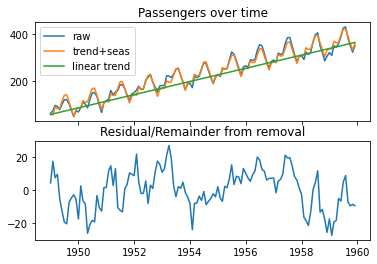

In [70]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(passengers_ts.date, passengers.passengers, label = 'raw')
ax1.plot(passengers_ts.date, passengers_ts.trend_seas, label = 'trend+seas')
ax1.plot(passengers_ts.date, passengers_ts.step * linreg.named_steps['model'].coef_[0] + linreg.named_steps['model'].intercept_, label = 'linear trend')
ax1.set_title('Passengers over time')
ax1.legend()


ax2.plot(passengers_ts.date, passengers_ts['remainder'])
ax2.set_title('Residual/Remainder from removal')

In [63]:
passengers_ts.to_csv('../00_data/passengers_residual.csv',index = False)

In [ ]:
ax1.plot(passengers_ts.date, passengers_ts.step * linreg.named_steps['model'].coef_[0] + linreg.named_steps['model'].intercept_, label = 'linear trend')


In [88]:
passengers

,date,passengers,month,step
0,1949-01-01,64,1,0
1,1949-02-01,75,2,1
2,1949-03-01,98,3,2
3,1949-04-01,93,4,3
4,1949-05-01,80,5,4
...,...,...,...,...
127,1959-08-01,430,8,127
128,1959-09-01,383,9,128
129,1959-10-01,351,10,129
130,1959-11-01,323,11,130


In [94]:

np.append([0], linreg.named_steps['model'].coef_[1:])

None


array([  0.        ,  -4.41433081,  26.26224747,  16.84791667,
        16.34267677,  44.5647096 ,  67.87765152,  66.46332071,
        33.13989899,   1.18011364, -30.05239899,  -4.55763889])

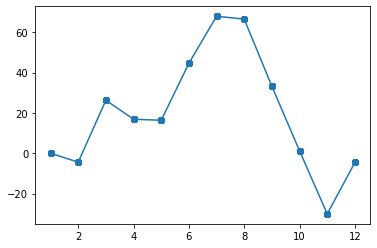

In [123]:
seasonal = [np.append([0], linreg.named_steps['model'].coef_[1:])[v-1] for v in passengers.month]


plt.scatter(passengers.month, seasonal)

plt.plot(passengers.month[0:12], seasonal[0:12])
